In [1]:
import sys

sys.path.append('../../..')

import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors

from batchflow.opensets import Imagenette160
from batchflow import Pipeline, B, V, C, W
from batchflow.models.torch.resnet import ResNet34
from batchflow.models.torch import ResBlock, SelfAttention
from batchflow.models.torch.layers import ConvBlock
from batchflow.models.metrics import ClassificationMetrics
from batchflow.utils import plot_results_by_config, show_research, print_results
from batchflow.research import Research, Option, Results, KV, RP, REU, RI

In [2]:
data = Imagenette160()

In [3]:
train_data = data.train
test_data = data.test

In [4]:
class SAResBlock(nn.Module):
    def __init__(self, **kwargs):
        super(SAResBlock, self).__init__()
        self.layer = ConvBlock({'base': ResBlock, **kwargs}, {'base': SelfAttention}, inputs=kwargs['inputs'])
        
    def forward(self, x):
        return self.layer(x)

In [5]:
domain = (Option('body', [KV({'encoder/blocks/base':SAResBlock}, 'SAResBlock'), 
                         KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': False}, 'ResBlock'),
                         KV({'encoder/blocks/base':ResBlock, 'encoder/blocks/se': True}, 'SEResBlock')]))

In [6]:
config = {
    'inputs': dict(labels={'classes': 10}),
    'optimizer': ('Adam', {'lr': 0.001}),
    'body': C('body'),
    'head': dict(layout='cV', kernel_size=1),
    'loss': 'ce',
    'device': C('device'),
}

In [7]:
train_pipeline = (train_data.p
                    .init_model('dynamic', ResNet34, 'my_model', config=config)
                    .init_variable('loss')
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype=np.float32)
                    .train_model('my_model', B('images'), B('labels'), 
                                   fetches='loss', save_to=V('loss'))
                    .run_later(64, n_epochs=None, drop_last=True, shuffle=True, bar=False)           
                 )

test_pipeline = (test_data.p
                    .import_model('my_model', C('import_from'))
                    .init_variable('true', [])
                    .update(V('true', mode='a'), B.labels) 
                    .init_variable('predictions', [])
                    .crop(shape=(160, 160), origin='center')
                    .to_array(channels='first', dtype=np.float32)
                    .predict_model('my_model', B('images'), fetches='predictions', save_to=V('predictions', mode='a'))
                    .run_later(128, n_epochs=1, drop_last=False, shuffle=True, bar=False)
                  
                )

In [8]:
def acc(iteration, experiment):
    pipeline = experiment.pipeline
    pred = np.concatenate(pipeline.v('predictions'))
    true = np.concatenate(pipeline.v('true'))
    accuracy = ClassificationMetrics(true, pred, fmt='logits', num_classes=10, axis=1).accuracy()
    return accuracy

In [9]:
research = (Research()
    .add_pipeline(train_pipeline, variables='loss', name='train_ppl', logging=True)
    .add_pipeline(test_pipeline, name='test_ppl',
                  execute=10, run=True, import_from=RP('train_ppl'))
    .add_callable(acc, returns='acc_vall', name='acc_fn', execute=10, iteration=RI(), experiment=REU('test_ppl'))
    .init_domain(domain, n_reps=5)
)

In [ ]:
!rm -r research

NUM_ITERS = 15000

research.run(NUM_ITERS, name='research', devices=[3, 4, 5], workers=3, bar=True)

rm: cannot remove 'research': No such file or directory
Research research_our_models is starting...


Domain updated: 0:   4%|▎         | 8130/225000.0 [22:10<9:51:36,  6.11it/s] 

In [12]:
results  = research.load_results(concat_config=True)

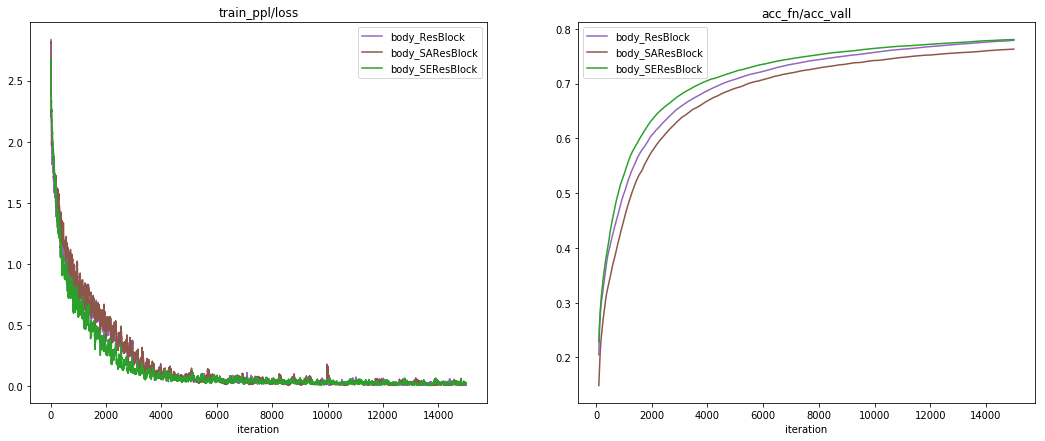

In [13]:
show_research(results.df, layout=['train_ppl/loss', 'acc_fn/acc_vall'], average_repetitions=True, 
              color=list(mcolors.TABLEAU_COLORS.keys()), log_scale=False, rolling_window=10)

In [14]:
print_results(results.df, 'acc_fn/acc_vall', False, ascending=True, n_last=10)

,acc_fn_4,acc_fn_3,acc_fn_0,acc_fn_mean,acc_fn_std
body_ResBlock,0.780730,0.780775,0.775744,0.779083,0.002361
body_SAResBlock,0.767013,0.758598,0.762806,0.004207,NaN
body_SEResBlock,0.775309,0.785357,0.780333,0.005024,NaN


In [16]:
#plot_results_by_config(results.df, (('train_ppl', 'loss'), ('acc_fn', 'acc_vall')))